In [1]:
!pip install scipy

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import pandas as pd
import numpy as np
import time

In [3]:
df = pd.read_csv("/Users/jeremyhudsonchan/Dropbox/Files/Github_Repos/Twitter-Sentiment-Analysis/data/sampled/training.1600000.processed.noemoticon.csv", encoding = "latin-1", low_memory=False)

In [4]:
df.head()

,ids,date,user,text,target
0,2265878782,Sun Jun 21 07:29:15 PDT 2009,MeeJong,This morning my daughter asked me if I hate my...,0
1,2205565064,Wed Jun 17 05:00:35 PDT 2009,kathysyahrizal,"I forgot to charge my bb, zzzzz only 35% left",0
2,2002872654,Tue Jun 02 05:22:07 PDT 2009,kgautam,my MBP battery is fluctuating between dead to ...,0
3,1835496893,Mon May 18 06:07:33 PDT 2009,thejanice,i really wish my landlord would call me back. ...,0
4,1573596472,Tue Apr 21 01:55:46 PDT 2009,lucyxechelon,mean blog people,0


In [5]:
df.shape

(50000, 5)

In [6]:
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [7]:
# use pretrained google word2vec model
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format("/Users/jeremyhudsonchan/Dropbox/Files/Github_Repos/Twitter-Sentiment-Analysis/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [8]:
# apply model_word2vec to each text in use_df
def word2vec(text):
    text = text.split()
    # use keyedvector's .get_vector() method to get the vector for each word in text
    # if word is not in model_word2vec, return a vector of 0s
    text = [model_word2vec.get_vector(word) if word in model_word2vec else np.zeros(300) for word in text]
    return text

# apply word2vec to each text in use_df
df['text'] = df['text'].apply(word2vec)

In [9]:
print(df['text'].head(1))

0    [[-0.2890625, 0.19921875, 0.16015625, 0.025268...
Name: text, dtype: object


In [10]:
# sum all the vectors in each text
def sum_vectors(text):
    text = np.array(text)
    text = np.sum(text, axis=0)
    return text

# apply sum_vectors to each text in use_df
df['text'] = df['text'].apply(sum_vectors)

In [11]:
print(df['text'].head(2))

0    [0.6248779296875, 0.260833740234375, 1.0648345...
1    [0.875732421875, 0.374603271484375, 0.68841552...
Name: text, dtype: object


In [12]:
print(len(df['text']))

50000


In [13]:
# check if each text has 300 elements
for i in range(len(df['text'])):
    if len(df['text'].iloc[i]) != 300:
        print(i)

In [14]:
# make use_df['text'] to a pandas dataframe with 300 columns, keeping the indexs
temp_df = pd.DataFrame(df['text'].tolist(), index=df.index)
# add target column to temp_df
temp_df['target'] = df['target']

In [15]:
temp_df['target'].head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [16]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('target', axis=1), temp_df['target'], test_size=0.2, random_state=5)

In [17]:
# logistic regression, with train_x being a list of lists
from sklearn.linear_model import LogisticRegression
def logistic_regression(train_x, train_y):
  classifier = LogisticRegression(max_iter=100000)
  classifier.fit(train_x, train_y)
  return classifier

# svm
from sklearn.svm import SVC
def svm(train_x, train_y):
    # take a subset of train_x and train_y
    classifier = SVC(max_iter=100000, C=1.0)
    classifier.fit(train_x, train_y)
    return classifier

# knn
from sklearn.neighbors import KNeighborsClassifier
def knn(train_x, train_y):
  # take a subset of train_x and train_y
  classifier = KNeighborsClassifier()
  classifier.fit(train_x, train_y)
  return classifier

# decision tree
from sklearn import tree
def decision_tree(train_x, train_y):
  classifier = tree.DecisionTreeClassifier()
  classifier.fit(train_x, train_y)
  return classifier

In [18]:
# run logistic regression
import time
start_time = time.time()
classifier = logistic_regression(X_train, y_train)
log_predictions = classifier.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.2993650436401367 seconds ---


In [19]:
# evaluate logistic regression
print(accuracy_score(y_test, log_predictions))
print(classification_report(y_test, log_predictions))
print(confusion_matrix(y_test, log_predictions))

0.7192
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      5010
           4       0.71      0.75      0.73      4990

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

[[3444 1566]
 [1242 3748]]


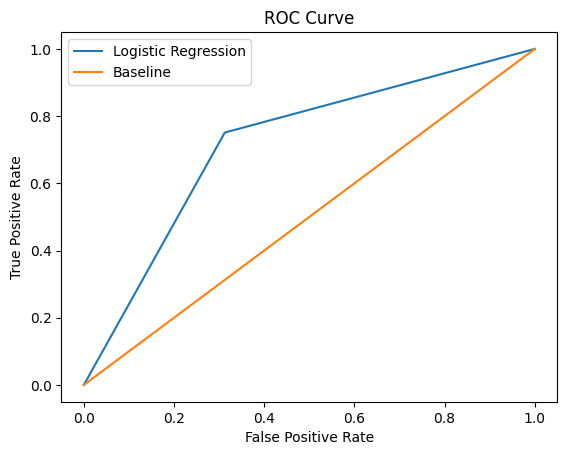

0.7192636770547082


In [20]:
# plot roc curve
log_fpr, log_tpr, log_thresold = roc_curve(y_test, log_predictions, pos_label=4)
plt.plot(log_fpr, log_tpr, label="Logistic Regression")
plt.plot([0,1], [0,1], label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
# print auc score
print(roc_auc_score(y_test, log_predictions))

In [21]:
# run svm
start_time = time.time()
classifier = svm(X_train, y_train)
predictions = classifier.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 606.711599111557 seconds ---


In [22]:
# evaluate svm
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.7352
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      5010
           4       0.73      0.75      0.74      4990

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

[[3588 1422]
 [1226 3764]]


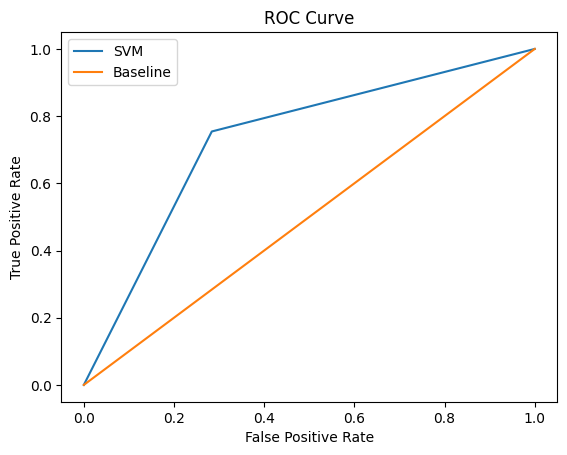

0.7352381409525639


In [23]:
# plot roc curve
svm_fpr, svm_tpr, svm_thresold = roc_curve(y_test, predictions, pos_label=4)
plt.plot(svm_fpr, svm_tpr, label="SVM")
plt.plot([0,1], [0,1], label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
# print auc score
print(roc_auc_score(y_test, predictions))

In [24]:
# run knn
start_time = time.time()
classifier = knn(X_train, y_train)
predictions = classifier.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.8315787315368652 seconds ---


In [25]:
# evaluate knn
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.6582
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      5010
           4       0.66      0.65      0.65      4990

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

[[3344 1666]
 [1752 3238]]


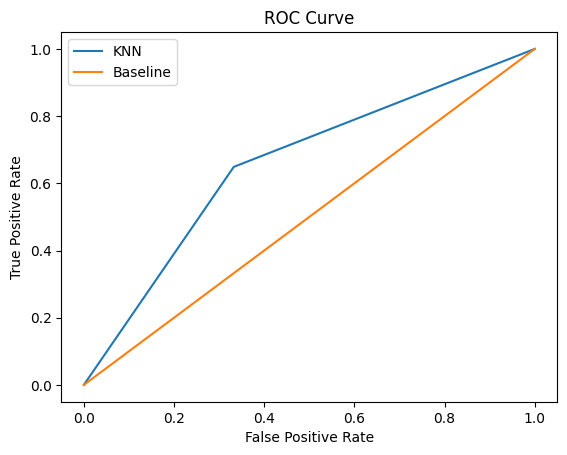

0.6581814327257308


In [26]:
# plot roc curve
knn_fpr, knn_tpr, knn_thresold = roc_curve(y_test, predictions, pos_label=4)
plt.plot(knn_fpr, knn_tpr, label="KNN")
plt.plot([0,1], [0,1], label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
# print auc score
print(roc_auc_score(y_test, predictions))

In [27]:
# run decision tree
start_time = time.time()
classifier = decision_tree(X_train, y_train)
predictions = classifier.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 17.941547870635986 seconds ---


In [28]:
# evaluate decision tree
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

0.598
              precision    recall  f1-score   support

           0       0.60      0.59      0.60      5010
           4       0.60      0.61      0.60      4990

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000

[[2953 2057]
 [1963 3027]]


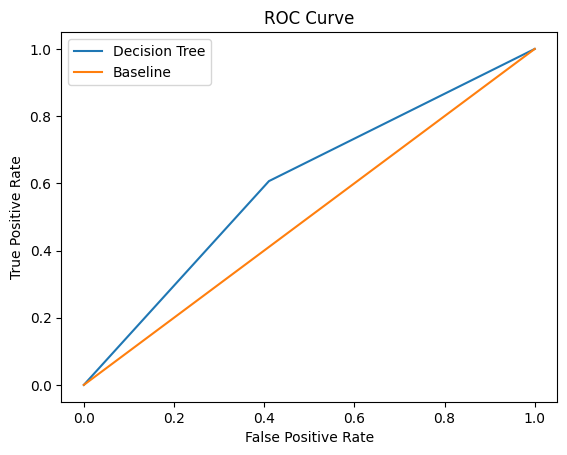

0.5980171920687682


In [29]:
# plot roc curve
dt_fpr, dt_tpr, dt_thresold = roc_curve(y_test, predictions, pos_label=4)
plt.plot(dt_fpr, dt_tpr, label="Decision Tree")
plt.plot([0,1], [0,1], label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
# print auc score
print(roc_auc_score(y_test, predictions))